# preprocessing prototype code

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# from dask_jobqueue import SLURMCluster
import cordex as cx
import xarray as xr
from dask.distributed import Client, progress
from pyintorg import interface as intf

import pyremo as pr

In [3]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:40386 Dashboard: /user/g300046/advanced//proxy/8787/status,Cluster Workers: 8 Cores: 48 Memory: 262.14 GB


In [90]:
from glob import glob

ta_file = "/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/6hrLev/ta/gn/v20190710/ta_6hrLev_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_197901010600-198001010000.nc"
ps_file = "/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/6hrLev/ps/gn/v20190710/ps_6hrLev_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_197501010600-198001010000.nc"
hus_file = "/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/6hrLev/hus/gn/v20190710/hus_6hrLev_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_197901010600-198001010000.nc"
ua_file = "/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/6hrLev/ua/gn/v20190815/ua_6hrLev_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_197901010600-198001010000.nc"
va_file = "/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/6hrLev/va/gn/v20190815/va_6hrLev_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_197901010600-198001010000.nc"
orog_file = "/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/fx/orog/gn/v20190710/orog_fx_MPI-ESM1-2-HR_historical_r1i1p1f1_gn.nc"
sftlf_file = "/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/fx/sftlf/gn/v20190710/sftlf_fx_MPI-ESM1-2-HR_historical_r1i1p1f1_gn.nc"
tos_file = "/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/Oday/tos/gn/v20190710/tos_Oday_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_19750101-19791231.nc"
tos_files = glob(
    "/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/Oday/tos/gn/v20190710/*"
)
tos_files.sort()

input_files = [orog_file, ta_file, ps_file, hus_file, ua_file, va_file]

In [245]:
surflib = pr.data.surflib("EUR-11", crop=False)
fibem = surflib.FIB * pr.preproc.const.grav_const
blaem = surflib.BLA

In [203]:
surflib.FIB

<xarray.DataArray 'FIB' (rlat: 435, rlon: 435)>
array([[295.70175 , 286.64117 , 278.18713 , ...,   0.      ,   0.      ,
          0.      ],
       [309.65698 , 296.71176 , 285.09302 , ...,   0.      ,   0.      ,
          0.      ],
       [328.1059  , 309.28656 , 293.1111  , ...,   0.      ,   0.      ,
          0.      ],
       ...,
       [  1.415902,   0.821212, 100.04256 , ..., 105.599525, 100.379715,
         65.78657 ],
       [ 24.602446,   0.438066, 134.84756 , ...,  54.492924,  48.390995,
         41.87234 ],
       [ 29.379206,  23.641336,  46.129517, ...,  16.798122,  31.954977,
         44.601414]], dtype=float32)
Coordinates:
  * rlon     (rlon) float64 -29.04 -28.93 -28.82 -28.71 ... 18.48 18.59 18.71
  * rlat     (rlat) float64 -24.04 -23.93 -23.82 -23.71 ... 23.48 23.59 23.71
Attributes:
    grid_mapping:  rotated_pole
    variable:      FIB
    description:   surface geopotential (orography)
    units:         m
    layer:         1.0
    cf_name:       orog
    code:          129

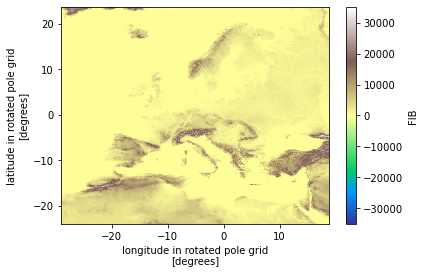

In [204]:
fibem.plot(cmap="terrain")

In [246]:
blaem

<xarray.DataArray 'BLA' (rlat: 435, rlon: 435)>
[189225 values with dtype=float32]
Coordinates:
  * rlon     (rlon) float64 -29.04 -28.93 -28.82 -28.71 ... 18.48 18.59 18.71
  * rlat     (rlat) float64 -24.04 -23.93 -23.82 -23.71 ... 23.48 23.59 23.71
Attributes:
    grid_mapping:  rotated_pole
    variable:      BLA
    description:   land sea mask
    units:         fract.
    layer:         1.0
    cf_name:       sftlf
    code:          172

In [8]:
cx.__version__

'0.1.2+dev'

In [86]:
datasets = {
    "ta": ta_file,
    "ps": ps_file,
    "hus": hus_file,
    "ua": ua_file,
    "va": va_file,
    "orog": orog_file,
    "sftlf": sftlf_file,
}

In [10]:
def open_mfdataset(
    files,
    use_cftime=True,
    parallel=True,
    data_vars="minimal",
    chunks={"time": 1},
    coords="minimal",
    compat="override",
    drop=None,
    **kwargs,
):
    """optimized function for opening CMIP6 6hrLev 3d datasets

    based on https://github.com/pydata/xarray/issues/1385#issuecomment-561920115

    """

    def drop_all_coords(ds):
        # ds = ds.drop(drop)
        return ds.reset_coords(drop=True)

    ds = xr.open_mfdataset(
        files,
        parallel=parallel,
        decode_times=False,
        combine="by_coords",
        preprocess=drop_all_coords,
        decode_cf=False,
        chunks=chunks,
        data_vars=data_vars,
        coords="minimal",
        compat="override",
        **kwargs,
    )
    return xr.decode_cf(ds, use_cftime=use_cftime)

In [11]:
lev_gm = "lev_gm"

In [19]:
def horizontal_dims(da):
    for dim in da.dims:
        if "lon" in dim:
            lon_dim = dim
        if "lat" in dim:
            lat_dim = dim
    return (lon_dim, lat_dim)


def intersect(lamgm, phigm, lamem, phiem):
    gcm_dims = list(horizontal_dims(lamgm))
    rcm_dims = list(horizontal_dims(lamem))
    rcm_dims.append("pos")
    out_dims = rcm_dims
    # print(gcm_dims)
    # print(rcm_dims)
    # print(out_dims)
    result = xr.apply_ufunc(
        intf.intersection_points,  # first the function
        lamgm * 1.0 / 57.296,  # now arguments in the order expected by 'druint'
        phigm * 1.0 / 57.296,
        lamem * 1.0 / 57.296,
        phiem * 1.0 / 57.296,
        input_core_dims=[
            gcm_dims,
            gcm_dims,
            rcm_dims,
            rcm_dims,
        ],  # list with one entry per arg
        output_core_dims=[out_dims, out_dims],  # returned data has 3 dimensions
        #   vectorize=True,  # loop over non-core dims, in this case: time
        #   exclude_dims=set(("lev",)),  # dimensions allowed to change size. Must be a set!
        dask="parallelized",
        output_dtypes=[lamgm.dtype],
    )
    return result


def interpolate_horizontal(da, lon, lat, name=None, igr=0):
    if name is None:
        name = da.name
    lamem, phiem = lon, lat
    # lamem = xr.concat([lamem, lamem, lamem], dim='pos')
    # phiem = xr.concat([phiem, phiem, phiem], dim='pos')
    lat2d, lon2d = xr.broadcast(ds.lat, ds.lon)
    lamgm, phigm = lon2d, lat2d
    indii, indjj = intersect(lamgm, phigm, lamem, phiem)
    return interp_horiz(
        da,
        lamgm,
        phigm,
        lamem.isel(pos=igr),
        phiem.isel(pos=igr),
        indii.isel(pos=igr),
        indjj.isel(pos=igr),
        name,
    )


def interp_horiz_2d(field, lamgm, phigm, lamem, phiem, indii, indjj, name):
    """interpolates 2d global data horizontally.

    Interpolates 2d data from the global grid to the regional grid.
    """
    from intorg import intorg

    # if indii is None or indjj is None:
    #    indii, indjj = intersection_points(lamgm, phigm, lamem, phiem)
    return intorg.hiobla(field, lamgm, phigm, lamem, phiem, indii, indjj, name)


def interp_horiz(da, lamgm, phigm, lamem, phiem, indii, indjj, name, keep_attrs=False):
    """main interface"""
    gcm_dims = list(horizontal_dims(lamgm))
    rcm_dims = list(horizontal_dims(lamem))
    input_core_dims = [
        gcm_dims,
        gcm_dims,
        gcm_dims,
        rcm_dims,
        rcm_dims,
        rcm_dims,
        rcm_dims,
        [],
    ]
    result = xr.apply_ufunc(
        interp_horiz_2d,  # first the function
        da,  # now arguments in the order expected
        lamgm * 1.0 / 57.296,
        phigm * 1.0 / 57.296,
        lamem * 1.0 / 57.296,
        phiem * 1.0 / 57.296,
        indii,
        indjj,
        name,
        input_core_dims=input_core_dims,  # list with one entry per arg
        output_core_dims=[rcm_dims],  # returned data has 3 dimensions
        vectorize=True,  # loop over non-core dims, in this case: time
        #  exclude_dims=set(("lev",)),  # dimensions allowed to change size. Must be a set!
        dask="parallelized",
        dask_gufunc_kwargs={"allow_rechunk": True},
        output_dtypes=[da.dtype],
    )

    result.name = name
    # result = result.to_dataset()
    if keep_attrs:
        result.attrs = da.attrs
    # result = result.transpose(..., *spatial_dims(da)[::-1])
    return result


def geopotential(fibgm, tgm, qdgm, psgm, akgm, bkgm):
    """main interface"""
    # gcm_dims = list(spatial_dims(lamgm))
    twoD_dims = list(horizontal_dims(fibgm))
    threeD_dims = list(horizontal_dims(fibgm))
    threeD_dims.append(lev_gm)
    # lev_dims.append("lev")
    # plev_dims = list(spatial_dims(da))
    # plev_dims.append("plev")
    # nlev = a.dims[0]
    input_core_dims = [
        twoD_dims,
        threeD_dims,
        threeD_dims,
        twoD_dims,
        ["lev_2"],
        ["lev_2"],
    ]
    result = xr.apply_ufunc(
        intf.geopotential,  # first the function
        fibgm,  # now arguments in the order expected
        tgm,
        qdgm,
        psgm,
        akgm,
        bkgm,
        input_core_dims=input_core_dims,  # list with one entry per arg
        #  output_core_dims=[threeD_dims],  # returned data has 3 dimensions
        output_core_dims=[twoD_dims],  # returned data has 3 dimensions
        # vectorize=True,  # loop over non-core dims, in this case: time
        # exclude_dims=set(("lev",)),  # dimensions allowed to change size. Must be a set!
        dask="parallelized",
        #  dask_gufunc_kwargs = {'allow_rechunk':True},
        output_dtypes=[fibgm.dtype],
    )
    return result


def relative_humidity(qdgm, tgm, psgm, akgm, bkgm, qwgm=None):
    """main interface"""
    if qwgm is None:
        qwgm = xr.zeros_like(qdgm)
    twoD_dims = list(horizontal_dims(qdgm))
    threeD_dims = list(horizontal_dims(qdgm)) + ["lev_gm"]
    #  print(twoD_dims)
    # threeD_dims.append("lev")
    input_core_dims = [
        threeD_dims,
        threeD_dims,
        twoD_dims,
        [akgm.dims[0]],
        [bkgm.dims[0]],
        threeD_dims,
    ]
    result = xr.apply_ufunc(
        intf.relative_humidity,  # first the function
        qdgm,  # now arguments in the order expected
        tgm,
        psgm,
        akgm,
        bkgm,
        qwgm,
        input_core_dims=input_core_dims,  # list with one entry per arg
        #  output_core_dims=[threeD_dims],  # returned data has 3 dimensions
        output_core_dims=[threeD_dims],  # returned data has 3 dimensions
        vectorize=True,  # loop over non-core dims, in this case: time
        # exclude_dims=set(("lev",)),  # dimensions allowed to change size. Must be a set!
        dask="parallelized",
        #  dask_gufunc_kwargs = {'allow_rechunk':True},
        output_dtypes=[qdgm.dtype],
    )
    return result


def geo_coords(domain):
    import numpy as np

    ll_lam = domain.rlon[0]  # * 1.0/57.296
    ll_phi = domain.rlat[0]  # * 1.0/57.296
    dlam = 0.11
    dphi = 0.11
    nlam = domain.rlon.size
    nphi = domain.rlat.size
    pollam = domain.rotated_latitude_longitude.grid_north_pole_longitude
    polphi = domain.rotated_latitude_longitude.grid_north_pole_latitude
    lamem, phiem = intf.geo_coords(
        ll_lam, ll_phi, dlam, dphi, pollam, polphi, nlam + 2, nphi + 2
    )
    lamda = xr.DataArray(
        np.rad2deg(lamem),
        dims=("rlon", "rlat", "pos"),
        coords={"rlon": fibem.rlon, "rlat": fibem.rlat},
    )
    phida = xr.DataArray(
        np.rad2deg(phiem),
        dims=("rlon", "rlat", "pos"),
        coords={"rlon": fibem.rlon, "rlat": fibem.rlat},
    )
    return lamda, phida

In [169]:
domain = pr.domain_info("EUR-11")
domain
# domain_info = dm.domain_info('AFR-11')
lamem, phiem = pr.preproc.geo_coords(domain, fibem.rlon, fibem.rlat)

In [173]:
import numpy as np
import xesmf as xe


def get_vc(ds):
    """Reads the vertical hybrid coordinate from a dataset."""
    ak_valid = ["ap_bnds", "a_bnds"]
    bk_valid = ["b_bnds"]
    ak_bnds = None
    bk_bnds = None
    for ak_name in ak_valid:
        if ak_name in ds:
            ak_bnds = ds[ak_name]
            print(f"using {ak_name} for akgm")
    for bk_name in bk_valid:
        if bk_name in ds:
            bk_bnds = ds[bk_name]
            print(f"using {bk_name} for bkgm")
    #    if not all([ak_bnds, bk_bnds]):
    #        print('could not identify vertical coordinate, tried: {}, {}'.format(ak_valid, bk_valid))
    #        raise Exception('incomplete input dataset')
    #        ak_bnds, bk_bnds  = (ak_bnds[:1], bk_bnds[:,1])
    nlev = ak_bnds.shape[0]
    ak = np.zeros([nlev + 1], dtype=np.float64)
    bk = np.ones([nlev + 1], dtype=np.float64)
    if ds.lev.positive == "down":
        ak[:-1] = np.flip(ak_bnds[:, 1])
        bk[:-1] = np.flip(bk_bnds[:, 1])
    else:
        ak[1:] = np.flip(ak_bnds[:, 1])
        bk[1:] = np.flip(bk_bnds[:, 1])

    return xr.DataArray(ak, dims="lev_2"), xr.DataArray(bk, dims="lev_2")


def tos_time_range(start, end, calendar, days=1):
    """compute time range for tos resampling

    Makes sure that the selected tos time range is large enough for resampling.

    """
    from datetime import datetime, timedelta

    import cftime

    startdate = datetime.strptime(start[0:10], "%Y-%m-%d").date()
    enddate = datetime.strptime(end[0:10], "%Y-%m-%d").date()
    cf_start = cftime.datetime(
        startdate.year, startdate.month, startdate.day, 12, calendar=calendar
    )
    cf_end = cftime.datetime(
        enddate.year, enddate.month, enddate.day, 12, calendar=calendar
    )
    return cf_start - timedelta(days=days), cf_end + timedelta(days=days)


def map_sst(tos, ref_ds, resample="6H", regrid=True):
    from datetime import timedelta as td

    tos_res = tos
    tos_times = (ref_ds.time.min() - td(days=1), ref_ds.time.max() + td(days=1))
    # if time_range:
    # tos_times = tos_time_range(*time_range, ref_ds.time.encoding['calendar'])
    print(tos_times)
    tos_res = tos_res.sel(time=slice(tos_times[0], tos_times[1]))
    # return tos_res
    tos_res = tos_res.resample(time=resample).interpolate("linear").chunk({"time": 1})
    tos_res = tos_res.sel(time=ref_ds.time)
    if regrid:
        regridder = xe.Regridder(tos_res, ref_ds, "nearest_s2d")
        tos_res = regridder(tos_res)
    return tos_res


def gfile(datasets, ref_ds, tos_ds, time_range=None):
    """Creates a virtual gfile"""
    lon, lat = horizontal_dims(ref_ds)
    if time_range is None:
        time_range = slice("1979-01-01T06:00:00", "1979-01-31T18:00:00")
    dsets = []
    for var, f in datasets.items():
        try:
            da = open_mfdataset(f, chunks={"time": 1})[var]
            da = da.sel(time=time_range)
        except:
            da = open_mfdataset(f, chunks={})[var]
        try:
            if da.lev.positive == "down":
                da = da.reindex(lev=da.lev[::-1])
        except:
            pass
        da[lon] = ref_ds[lon]
        da[lat] = ref_ds[lat]
        dsets.append(da)

    ds = xr.merge(dsets, compat="override")
    ds["tos"] = map_sst(tos_ds.tos, ref_ds.sel(time=time_range))
    ds["akgm"], ds["bkgm"] = get_vc(ref_ds)
    ds = ds.rename({"lev": lev_gm})
    ds.attrs = ref_ds.attrs
    ds = convert_units(ds)
    return ds

In [22]:
from pyremo.preproc import core as preproc

In [23]:
ref_ds = open_mfdataset(ta_file)
tos_ds = open_mfdataset(tos_files)
time_range = "1979-01"

In [24]:
tos_ds.tos

<xarray.DataArray 'tos' (time: 60265, j: 404, i: 802)>
dask.array<_apply_mask, shape=(60265, 404, 802), dtype=float32, chunksize=(1, 404, 802), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) object 1850-01-01 12:00:00 ... 2014-12-31 12:00:00
  * j          (j) int32 0 1 2 3 4 5 6 7 8 ... 396 397 398 399 400 401 402 403
  * i          (i) int32 0 1 2 3 4 5 6 7 8 ... 794 795 796 797 798 799 800 801
    latitude   (j, i) float64 dask.array<chunksize=(404, 802), meta=np.ndarray>
    longitude  (j, i) float64 dask.array<chunksize=(404, 802), meta=np.ndarray>
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      Sea Surface Temperature
    comment:        Temperature of upper boundary of the liquid ocean, includ...
    units:          degC
    original_name:  tos
    cell_methods:   area: mean where sea time: mean
    cell_measures:  area: areacello
    history:        2019-08-25T06:00:45Z altered by CMOR: replaced missing va...

In [242]:
ds = preproc.gfile(
    datasets,
    ref_ds,
    tos=tos_ds.tos,
    time_range=slice("1979-01-01T06:00:00", "1979-02-01T00:00:00"),
)

/work/ch0636/g300046/conda_envs/pyremo/lib/python3.9/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/work/ch0636/g300046/conda_envs/pyremo/lib/python3.9/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.arr

using ap_bnds for akgm
using b_bnds for bkgm
converting sftlf units to fractional
converting tos units to K
converting orography to geopotential


/work/ch0636/g300046/conda_envs/pyremo/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


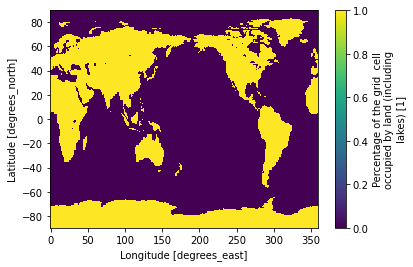

In [243]:
ds.sftlf.plot()

In [122]:
tge = interpolate_horizontal(ds.ta, lamem, phiem, "T")
psge = interpolate_horizontal(ds.ps, lamem, phiem, "PS")
uge = interpolate_horizontal(ds.ua, lamem, phiem, "U", 1)
uvge = interpolate_horizontal(ds.ua, lamem, phiem, "U", 2)
vge = interpolate_horizontal(ds.va, lamem, phiem, "V", 2)
vuge = interpolate_horizontal(ds.va, lamem, phiem, "V", 1)
qdge = interpolate_horizontal(ds.hus, lamem, phiem, "QD")
fibge = interpolate_horizontal(ds.orog, lamem, phiem, "FIB")

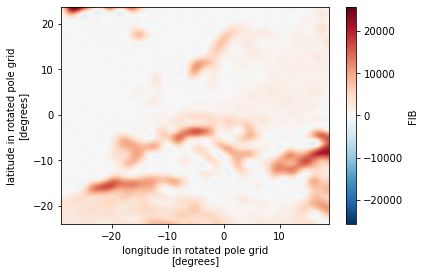

In [123]:
fibge.plot(x="rlon", y="rlat")

### geopotential

In [124]:
ficgm = geopotential(
    ds.orog,
    ds.ta.isel(time=0),
    ds.hus.isel(time=0),
    ds.ps.isel(time=0),
    ds.akgm,
    ds.bkgm,
).squeeze(drop=True)
ficge = interpolate_horizontal(ficgm, lamem, phiem, "FIC")
arfgm = relative_humidity(ds.hus, ds.ta, ds.ps, ds.akgm, ds.bkgm)
arfge = interpolate_horizontal(arfgm, lamem, phiem, "AREL HUM")

In [125]:
# RELHUM: hur relative_humidity
# QD hus specific_humidity
# QW: clw mass_fraction_of_cloud_liquid_water_in_air

### rotate UV

In [126]:
def rotate_uv(uge, vge, uvge, vuge, lamem, phiem, pollam, polphi):
    ulamem, uphiem = lamem.isel(pos=1), phiem.isel(pos=1)
    vlamem, vphiem = lamem.isel(pos=2), phiem.isel(pos=2)
    twoD_dims = list(horizontal_dims(uge))
    input_core_dims = 4 * [twoD_dims + [lev_gm]] + 4 * [twoD_dims] + 2 * [[]]
    print(input_core_dims)
    uge_rot, vge_rot = xr.apply_ufunc(
        intf.rotate_uv,  # first the function
        uge,  # now arguments in the order expected
        vge,
        uvge,
        vuge,
        ulamem * 1.0 / 57.296,
        uphiem * 1.0 / 57.296,
        vlamem * 1.0 / 57.296,
        vphiem * 1.0 / 57.296,
        pollam,
        polphi,
        input_core_dims=input_core_dims,  # list with one entry per arg
        #  output_core_dims=[threeD_dims],  # returned data has 3 dimensions
        output_core_dims=2 * [twoD_dims + [lev_gm]],  # returned data has 3 dimensions
        vectorize=True,  # loop over non-core dims, in this case: time
        # exclude_dims=set(("lev",)),  # dimensions allowed to change size. Must be a set!
        dask="parallelized",
        #  dask_gufunc_kwargs = {'allow_rechunk':True},
        output_dtypes=[uge.dtype, vge.dtype],
    )
    return uge_rot, vge_rot

In [127]:
uge

,Array,Chunk
Bytes,8.92 GB,71.91 MB
Shape,"(124, 95, 435, 435)","(1, 95, 435, 435)"
Count,3672 Tasks,124 Chunks
Type,float32,numpy.ndarray


In [128]:
pollon = domain.rotated_latitude_longitude.grid_north_pole_longitude
pollat = domain.rotated_latitude_longitude.grid_north_pole_latitude
uge_rot, vge_rot = rotate_uv(uge, vge, uvge, vuge, lamem, phiem, pollon, pollat)

[['rlon', 'rlat', 'lev_gm'], ['rlon', 'rlat', 'lev_gm'], ['rlon', 'rlat', 'lev_gm'], ['rlon', 'rlat', 'lev_gm'], ['rlon', 'rlat'], ['rlon', 'rlat'], ['rlon', 'rlat'], ['rlon', 'rlat'], [], []]


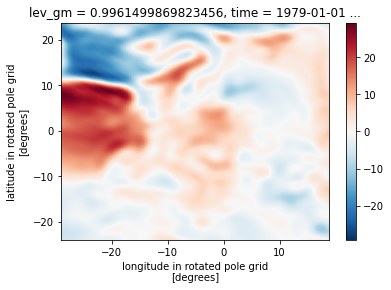

In [129]:
uge_rot.isel(time=0, lev_gm=94).plot(x="rlon", y="rlat")

### first pressure correction

In [130]:
def pressure_correction_em(psge, tge, arfge, fibge, fibem, akgm, bkgm, kpbl):
    twoD_dims = list(horizontal_dims(psge))
    threeD_dims = list(horizontal_dims(psge)) + [lev_gm]
    input_core_dims = (
        [twoD_dims]
        + 2 * [threeD_dims]
        + 2 * [twoD_dims]
        + [[akgm.dims[0]], [bkgm.dims[0]], []]
    )
    # print(input_core_dims)
    result = xr.apply_ufunc(
        intf.pressure_correction_em,  # first the function
        psge,  # now arguments in the order expected
        tge,
        arfge,
        fibge,
        fibem,
        akgm,
        bkgm,
        kpbl,
        input_core_dims=input_core_dims,  # list with one entry per arg
        output_core_dims=[twoD_dims],  # returned data has 3 dimensions
        vectorize=True,  # loop over non-core dims, in this case: time
        dask="parallelized",
        output_dtypes=[psge.dtype],
    )
    return result

In [131]:
kpbl = intf.pbl_index(ds.akgm, ds.bkgm)
kpbl

89

In [132]:
ps1em = pressure_correction_em(psge, tge, arfge, fibge, fibem, ds.akgm, ds.bkgm, kpbl)

In [133]:
ps1em

<xarray.DataArray (time: 124, rlon: 435, rlat: 435)>
dask.array<transpose, shape=(124, 435, 435), dtype=float32, chunksize=(1, 435, 435), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1979-01-01 06:00:00 ... 1979-02-01 00:00:00
  * rlon     (rlon) float64 -29.04 -28.93 -28.82 -28.71 ... 18.48 18.59 18.71
  * rlat     (rlat) float64 -24.04 -23.93 -23.82 -23.71 ... 23.48 23.59 23.71

### vertical interpolation

In [134]:
def interpolate_vertical(xge, psge, ps1em, akhgm, bkhgm, akhem, bkhem, varname, kpbl):
    twoD_dims = list(horizontal_dims(psge))
    threeD_dims = list(horizontal_dims(psge)) + [lev_gm]
    input_core_dims = (
        [threeD_dims]
        + 2 * [twoD_dims]
        + [[akhgm.dims[0]], [bkhgm.dims[0]], [akhem.dims[0]], [bkhem.dims[0]], [], []]
    )
    output_core_dims = [twoD_dims + [akhem.dims[0]]]
    print(output_core_dims)
    result = xr.apply_ufunc(
        intf.interp_vert,  # first the function
        xge,  # now arguments in the order expected
        psge,
        ps1em,
        akhgm,
        bkhgm,
        akhem,
        bkhem,
        varname,
        kpbl,
        input_core_dims=input_core_dims,  # list with one entry per arg
        output_core_dims=output_core_dims,  # returned data has 3 dimensions
        # exclude_dims=set(("index",)),
        vectorize=True,  # loop over non-core dims, in this case: time
        dask="parallelized",
        output_dtypes=[xge.dtype],
    )
    return result


# interp_vert(tge, psge, ps1em, varmap.akhgm, varmap.bkhgm, varmap.akhem, varmap.bkhem, varname, kpbl)

In [135]:
akhgm = 0.5 * (ds.akgm[:-1] + ds.akgm[1:])
bkhgm = 0.5 * (ds.bkgm[:-1] + ds.bkgm[1:])
dakgm = ds.akgm[1:] - ds.akgm[:-1]
dbkgm = ds.bkgm[1:] - ds.bkgm[:-1]

In [136]:
pr.vc.tables.keys()

dict_keys(['vc_27lev', 'vc_40lev', 'vc_49lev', 'vc_49lev_nh_pt2000', 'vc_60lev_ecmwf', 'vc_91lev_ecmwf', 'vc_101lev_100m_pt27713', 'vc_144lev_equal_pdiff_pt6400'])

In [198]:
lev_i = "lev_i"
lev = "lev"
# it's important to drop the index so that xarray does not
akibki = pr.vc.tables["vc_27lev"].to_xarray().drop("index")
# bkem = pr.tables.vc.tables['vc_27lev']
akem = akibki.ak.swap_dims({"index": lev_i})
bkem = akibki.bk.swap_dims({"index": lev_i})
akhem = (0.5 * (akibki.ak[:-1] + akbk.ak[1:])).swap_dims({"index": lev})
bkhem = (0.5 * (akibki.bk[:-1] + akbk.bk[1:])).swap_dims({"index": lev})

In [138]:
akem[lev_i] = xr.DataArray(np.arange(1, akem.size + 1), dims=lev_i)
bkem[lev_i] = xr.DataArray(np.arange(1, bkem.size + 1), dims=lev_i)
akhem[lev] = xr.DataArray(np.arange(1, akhem.size + 1), dims=lev)
bkhem[lev] = xr.DataArray(np.arange(1, bkhem.size + 1), dims=lev)

In [193]:
akbk = pr.preproc.core.vch(pr.vc.tables["vc_27lev"])

In [140]:
dakhgm = ds.akgm.diff(dim="lev_2")
dbkhgm = ds.bkgm.diff(dim="lev_2")

In [141]:
tge

,Array,Chunk
Bytes,8.92 GB,71.91 MB
Shape,"(124, 95, 435, 435)","(1, 95, 435, 435)"
Count,3672 Tasks,124 Chunks
Type,float32,numpy.ndarray


In [142]:
tem = interpolate_vertical(tge, psge, ps1em, akhgm, bkhgm, akhem, bkhem, "T", kpbl)
arfem = interpolate_vertical(arfge, psge, ps1em, akhgm, bkhgm, akhem, bkhem, "RF", kpbl)

[['rlon', 'rlat', 'lev']]
[['rlon', 'rlat', 'lev']]


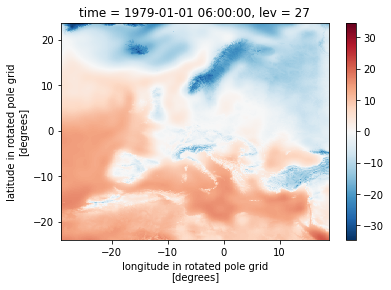

In [143]:
(tem.isel(time=0, lev=26) - 273.5).plot(x="rlon", y="rlat")

### second pressure correction

In [144]:
def pressure_correction_ge(ps1em, tem, arfem, ficge, fibem, akem, bkem):
    twoD_dims = list(horizontal_dims(psge))
    threeD_dims = list(horizontal_dims(psge)) + [lev]
    input_core_dims = (
        [twoD_dims]
        + 2 * [threeD_dims]
        + 2 * [twoD_dims]
        + [[akem.dims[0]], [bkem.dims[0]]]
    )
    # print(input_core_dims)
    result = xr.apply_ufunc(
        intf.pressure_correction_ge,  # first the function
        ps1em,  # now arguments in the order expected
        tem,
        arfem,
        ficge,
        fibem,
        akem,
        bkem,
        input_core_dims=input_core_dims,  # list with one entry per arg
        output_core_dims=[twoD_dims],  # returned data has 3 dimensions
        vectorize=True,  # loop over non-core dims, in this case: time
        dask="parallelized",
        output_dtypes=[ps1em.dtype],
    )
    return result

In [145]:
tem

,Array,Chunk
Bytes,2.53 GB,20.44 MB
Shape,"(124, 435, 435, 27)","(1, 435, 435, 27)"
Count,24445 Tasks,124 Chunks
Type,float32,numpy.ndarray


In [146]:
psem = pressure_correction_ge(ps1em, tem, arfem, ficge, fibem, akem, bkem)

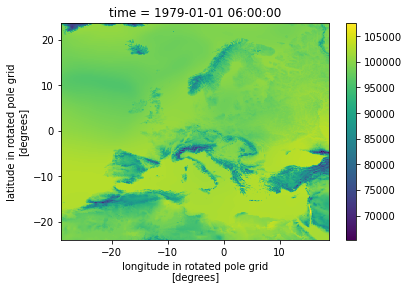

In [147]:
psem[0].plot(x="rlon", y="rlat")

In [148]:
uem = interpolate_vertical(uge_rot, psge, psem, akhgm, bkhgm, akhem, bkhem, "U", kpbl)
vem = interpolate_vertical(vge_rot, psge, psem, akhgm, bkhgm, akhem, bkhem, "V", kpbl)

[['rlon', 'rlat', 'lev']]
[['rlon', 'rlat', 'lev']]


In [149]:
uem

,Array,Chunk
Bytes,2.53 GB,20.44 MB
Shape,"(124, 435, 435, 27)","(1, 435, 435, 27)"
Count,34531 Tasks,124 Chunks
Type,float32,numpy.ndarray


In [150]:
xem_ = tem.isel(time=0).persist()
progress(xem_)

VBox()

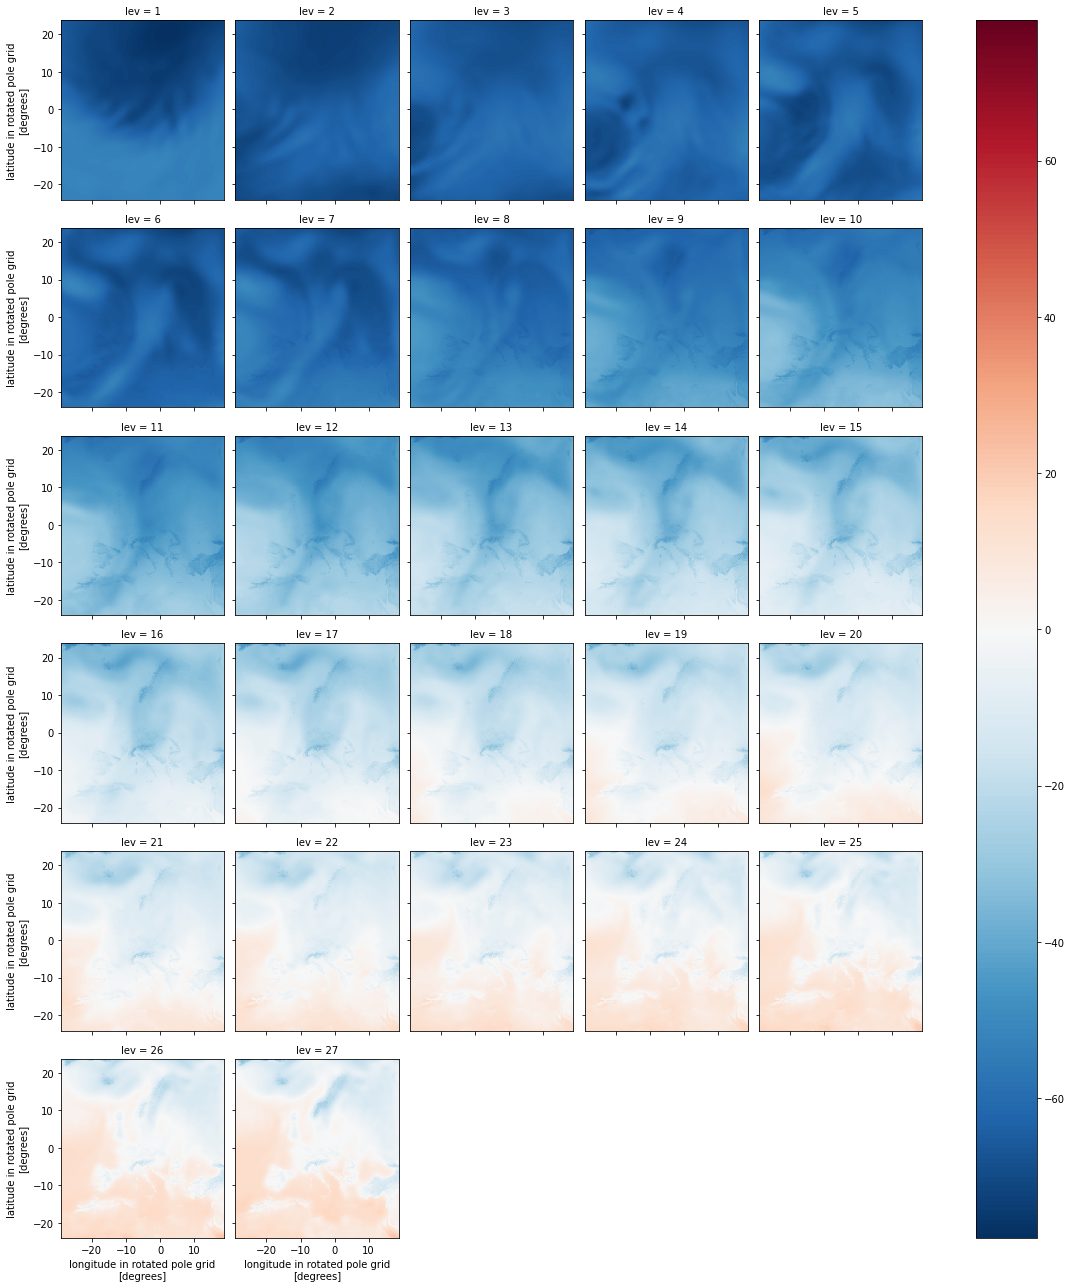

In [151]:
(xem_ - 273.5).plot(x="rlon", y="rlat", col=lev, col_wrap=5)

In [152]:
def correct_uv(uem, vem, psem, akem, bkem, ll_lam, dlam, dphi):
    ulamem, uphiem = lamem.isel(pos=1), phiem.isel(pos=1)
    vlamem, vphiem = lamem.isel(pos=2), phiem.isel(pos=2)
    twoD_dims = list(horizontal_dims(uem))
    input_core_dims = (
        2 * [twoD_dims + [lev]]
        + 1 * [twoD_dims]
        + [[akem.dims[0]], [bkem.dims[0]]]
        + 3 * [[]]
    )
    # print(input_core_dims)
    uge_corr, vge_corr = xr.apply_ufunc(
        intf.correct_uv,  # first the function
        uem,  # now arguments in the order expected
        vem,
        psem,
        akem,
        bkem,
        ll_lam,
        dlam,
        dphi,
        input_core_dims=input_core_dims,  # list with one entry per arg
        #  output_core_dims=[threeD_dims],  # returned data has 3 dimensions
        output_core_dims=2 * [twoD_dims + [lev]],  # returned data has 3 dimensions
        vectorize=True,  # loop over non-core dims, in this case: time
        # exclude_dims=set(("lev",)),  # dimensions allowed to change size. Must be a set!
        dask="parallelized",
        #  dask_gufunc_kwargs = {'allow_rechunk':True},
        output_dtypes=[uem.dtype, vem.dtype],
    )
    return uge_corr, vge_corr

In [153]:
philuem = pr.domain_info("EUR-11")["ll_lon"]
dlamem = pr.domain_info("EUR-11")["dlon"]
dphiem = pr.domain_info("EUR-11")["dlat"]
philuem, dlamem, dphiem

(-28.925, 0.11, 0.11)

In [154]:
uem_corr, vem_corr = correct_uv(uem, vem, psem, akem, bkem, philuem, dlamem, dphiem)

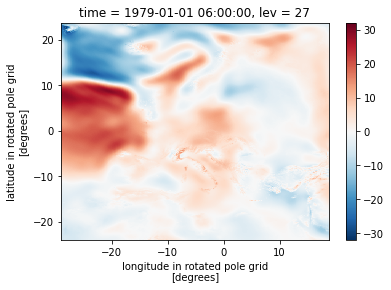

In [155]:
uem_corr.isel(time=0, lev=26).plot(x="rlon", y="rlat")

### sst interpolation

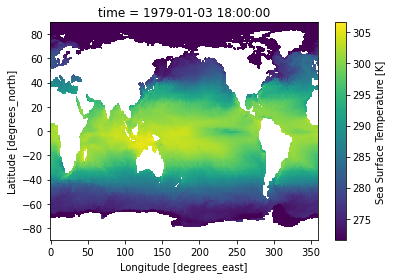

In [205]:
ds.tos[10].plot()

In [207]:
lat2d, lon2d = xr.broadcast(ds.lat, ds.lon)
lamgm, phigm = lon2d, lat2d


tsw = pr.preproc.core.interpolate_horizontal(ds.ta, lamem, phiem, lamgm, phigm, "T")

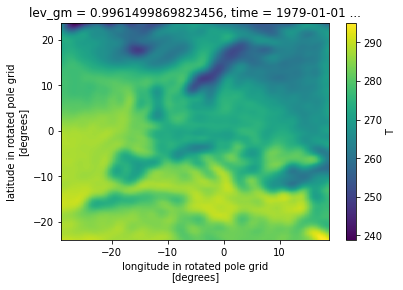

In [211]:
tsw.isel(time=0, lev_gm=94).plot(x="rlon", y="rlat")

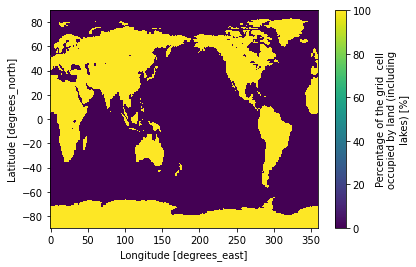

In [217]:
ds.sftlf.plot()

In [258]:
ds

<xarray.Dataset>
Dimensions:  (lat: 192, lev_2: 96, lev_gm: 95, lon: 384, time: 124)
Coordinates:
  * lev_gm   (lev_gm) float64 9.816e-06 2.31e-05 3.079e-05 ... 0.9826 0.9961
  * time     (time) object 1979-01-01 06:00:00 ... 1979-02-01 00:00:00
  * lat      (lat) float64 -89.28 -88.36 -87.42 -86.49 ... 87.42 88.36 89.28
  * lon      (lon) float64 0.0 0.9375 1.875 2.812 ... 356.2 357.2 358.1 359.1
Dimensions without coordinates: lev_2
Data variables:
    ta       (time, lev_gm, lat, lon) float32 dask.array<chunksize=(1, 95, 192, 384), meta=np.ndarray>
    ps       (time, lat, lon) float32 dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    hus      (time, lev_gm, lat, lon) float32 dask.array<chunksize=(1, 95, 192, 384), meta=np.ndarray>
    ua       (time, lev_gm, lat, lon) float32 dask.array<chunksize=(1, 95, 192, 384), meta=np.ndarray>
    va       (time, lev_gm, lat, lon) float32 dask.array<chunksize=(1, 95, 192, 384), meta=np.ndarray>
    orog     (lat, lon) float32 dask.array<chunksize=(192, 384), meta=np.ndarray>
    sftlf    (lat, lon) float32 dask.array<chunksize=(192, 384), meta=np.ndarray>
    tos      (time, lat, lon) float64 dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    akgm     (lev_2) float64 0.0 1.989 2.693 3.546 4.577 ... 72.06 0.0 0.0 0.0
    bkgm     (lev_2) float64 0.0 0.0 0.0 0.0 0.0 ... 0.9442 0.973 0.9923 1.0
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    contact:                cmip6-mpi-esm@dkrz.de
    ...                     ...
    title:                  MPI-ESM1-2-HR output prepared for CMIP6
    variable_id:            ta
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/e7cf2db1-51d1-4692-a1ff-60e2d204b533

In [268]:
ds.sftlf

<xarray.DataArray 'sftlf' (lat: 192, lon: 384)>
dask.array<mul, shape=(192, 384), dtype=float32, chunksize=(192, 384), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.28 -88.36 -87.42 -86.49 ... 87.42 88.36 89.28
  * lon      (lon) float64 0.0 0.9375 1.875 2.812 ... 356.2 357.2 358.1 359.1
Attributes:
    standard_name:   land_area_fraction
    long_name:       Percentage of the grid  cell occupied by land (including...
    comment:         Percentage of horizontal area occupied by land.
    units:           1
    original_name:   slm
    original_units:  1
    history:         2020-03-04T09:13:43Z altered by CMOR: Converted units fr...
    cell_methods:    area: mean
    cell_measures:   area: areacella

In [271]:
ds.sftlf

<xarray.DataArray 'sftlf' (lat: 192, lon: 384)>
dask.array<mul, shape=(192, 384), dtype=float32, chunksize=(192, 384), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.28 -88.36 -87.42 -86.49 ... 87.42 88.36 89.28
  * lon      (lon) float64 0.0 0.9375 1.875 2.812 ... 356.2 357.2 358.1 359.1
Attributes:
    standard_name:   land_area_fraction
    long_name:       Percentage of the grid  cell occupied by land (including...
    comment:         Percentage of horizontal area occupied by land.
    units:           1
    original_name:   slm
    original_units:  1
    history:         2020-03-04T09:13:43Z altered by CMOR: Converted units fr...
    cell_methods:    area: mean
    cell_measures:   area: areacella

In [275]:
tsw = pr.preproc.core.interpolate_horizontal(
    ds.tos, lamem, phiem, lamgm, phigm, "TSW", blagm=ds.sftlf, blaem=blaem
)

In [276]:
tsw

<xarray.DataArray 'TSW' (time: 124, rlon: 435, rlat: 435)>
dask.array<transpose, shape=(124, 435, 435), dtype=float64, chunksize=(1, 435, 435), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1979-01-01 06:00:00 ... 1979-02-01 00:00:00
  * rlon     (rlon) float64 -29.04 -28.93 -28.82 -28.71 ... 18.48 18.59 18.71
  * rlat     (rlat) float64 -24.04 -23.93 -23.82 -23.71 ... 23.48 23.59 23.71

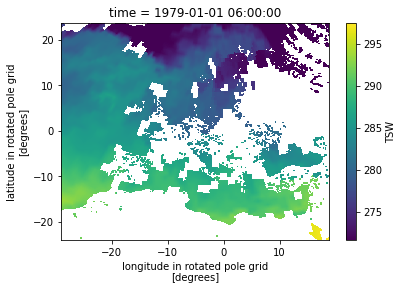

In [277]:
tsw.isel(time=0).plot(x="rlon", y="rlat")